In [0]:
from bayes.vi import VIModel, normal_prior_dist, transform_param
from bayes.nn import TensorModule, TensorBatchNorm1d, TensorLinear
from bayes.distributions.normal import CustomNormal

In [0]:
from functools import reduce
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.distributions as torchdist
import torch.nn as nn
import torch.nn.functional as F
import itertools
from collections import OrderedDict
from sklearn.preprocessing import StandardScaler

## Data

In [0]:
normal_dist = torchdist.Normal(loc=torch.tensor(0.), scale=torch.tensor(1.))

In [0]:
x = normal_dist.sample()

In [8]:
x

tensor(0.3412)

In [0]:
x = normal_dist.sample([100])

In [10]:
x

tensor([ 1.2461, -0.2444,  0.4986, -0.9544,  1.7865, -1.3674,  1.4401, -0.2295,
        -0.7820,  1.1109, -0.2596, -0.7353,  0.6927, -0.1494, -3.2609, -0.0922,
        -0.3140, -0.5662,  1.2151, -2.3658,  0.9579, -0.2183,  1.7288, -1.0218,
         1.4809, -0.3390, -1.5418, -1.7462,  0.0822,  0.7885, -1.0372, -2.2964,
         0.5984, -0.5970,  0.6742,  0.4825, -0.2378,  0.3588,  0.8235,  0.4346,
        -0.4037,  0.7673, -0.1934, -0.6083, -0.3902,  1.2294,  1.4039,  0.6729,
         1.5778,  0.3822, -1.3409, -0.3802, -1.8699, -0.0166, -1.0247,  1.5328,
        -1.4693,  0.4601, -1.1457,  0.5511,  0.7025, -0.6798,  1.4002,  1.0631,
        -1.1666,  0.3631,  0.3006,  1.0269, -1.4445,  0.7830,  0.5214,  0.5824,
         1.7447, -0.3397,  1.0155, -1.2171,  0.7347, -0.3530,  0.0971,  1.0050,
        -0.6425, -0.1994, -0.2358,  0.8466, -0.5755, -0.2180, -0.8671, -0.2163,
        -1.8609,  0.6655,  1.3986, -1.7998, -0.2568, -0.4790,  0.2643, -0.4827,
        -0.1577, -0.2443, -0.4354, -0.36

(array([ 1.,  2.,  3.,  6.,  9., 24., 13., 19., 13., 10.]),
 array([-3.2608948 , -2.7561526 , -2.2514105 , -1.7466683 , -1.2419262 ,
        -0.737184  , -0.23244183,  0.27230033,  0.7770425 ,  1.2817847 ,
         1.7865268 ], dtype=float32),
 <a list of 10 Patch objects>)

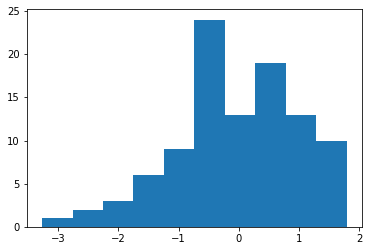

In [11]:
plt.hist(x.detach().numpy())

In [0]:
def toy_poly():
    x = 5 * torch.rand(100, 1)
    # linear_op = -3 - 4*x + x**2
    # linear_op = -3 - 4*x + 2*x**2 - x*x*x / 5
    linear_op = 4 * torch.sin(x*2)
    y = torchdist.Normal(linear_op, 0.5).sample()
    return x, y

x_train, y_train = toy_poly()

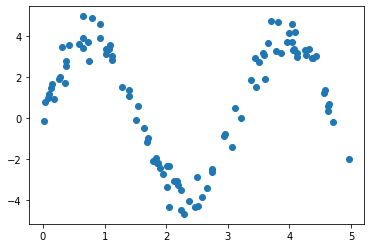

In [13]:
plt.plot(x_train.numpy(), y_train.numpy(), 'o')

## Normalizing Flows


\begin{align}
q(z') = q(z) \left| \mathrm{det} \frac{\partial f}{\partial z'} \right| = q(z) \left| \mathrm{det} \frac{\partial f}{\partial z} \right|^{-1}
\end{align}

\begin{align}
\ln q_K(z_K) = \ln q_0(z_0) - \sum_{k=1}^{K} \ln \left| \mathrm{det} \frac{\partial f_k}{\partial z_k} \right|
\end{align}

planar flow
\begin{align}
f(z) = z + uh(w^\top z + b)
\end{align}
\begin{align}
\mathrm{det} \left| \frac{\partial f}{\partial z} \right| = |\mathrm{det}(I + u\psi(z)^\top)| = |1 + u^\top \psi(z)|
\end{align}
\begin{align}
\psi(z) = h'(w^\top z + b)w
\end{align}

## module

In [0]:
class TensorLinearNet(TensorModule):
    def __init__(self):
        super(TensorLinearNet, self).__init__()
        n = 4
        self.linear1 = TensorLinear(1, n)
        self.linear2 = TensorLinear(n, n)
        self.linear3 = TensorLinear(n, n)
        self.linear4 = TensorLinear(n, n)

        self.last_layer = TensorLinear(n, 1)

        self.bn1 = nn.BatchNorm1d(n, affine=False)
        self.bn2 = nn.BatchNorm1d(n, affine=False)
        self.bn3 = nn.BatchNorm1d(n, affine=False)
        self.bn4 = nn.BatchNorm1d(n, affine=False)
        # self.bn1 = TensorBatchNorm1d(n, affine=False)
        # self.bn2 = TensorBatchNorm1d(n, affine=False)
        # self.bn3 = TensorBatchNorm1d(n, affine=False)
        # self.bn4 = TensorBatchNorm1d(n, affine=False)

    def forward(self, x):
        x = self.linear1(x)
        x = self.bn1(x)
        x = F.relu(x)

        x = self.linear2(x)
        x = self.bn2(x)
        x = F.relu(x)

        x = self.linear3(x)
        x = self.bn3(x)
        x = F.relu(x)

        x = self.linear4(x)
        x = self.bn4(x)
        x = F.relu(x)

        x = self.last_layer(x)

        x1 = x
        x2 = None

        return x1, x2

## Variational Inference

$$
\begin{align}
& KL[q(W; \eta)||p(W|X, Y)] \\
&= \int q(W; \eta) \log \frac{q(W; \eta)}{p(W|X, Y)} dW\\
&= \int q(W; \eta) \log q(W; \eta)dW - \int q(W; \eta) \log \frac{p(Y|W, X)p(W)}{p(Y|X)}dW \\
&= \int q(W; \eta) \log q(W; \eta)dW - \int q(W; \eta) \log p(Y|W, X)dW - \int q(W; \eta) \log p(W)dW + const.\\
&= E[\log q(W; \eta)] - E[\log p(Y|W, X)] - E[\log p(W)] + const.
\end{align}
$$

\begin{align}
E[\log p(Y|W, X)] = E\left[\sum log p(y_i|W, x_i)\right]
\end{align}

In [0]:
def kl_divergence(q_w, p_w, loc_dict, model, x, y, idx):

    # sampling from q(w)
    zs = q_w.rsample()
    # z_0 = zs[0]
    w_sample = zs[-1]

    param_dict = transform_param(w_sample, loc_dict)
    model.set_params(param_dict)

    # calculate f(x)
    # p(y|x,w) = N(f(x; w), 1)
    out1, out2 = model(x)
    if out1.size(-1) != 1:
        raise ValueError

    p_y_xw = torchdist.Normal(out1, torch.ones_like(out1) / 2)
    # p_y_xw = torchdist.Normal(out1, out2)

    def temp(i):
        return min(1, 0.01 + i / 10000)

    # log(p(w, x, y)) = log(p(w)) + sum(log(p(y|x,w)))
    val_log_p_w = p_w.log_prob(w_sample).sum()
    val_log_p_y_xw = p_y_xw.log_prob(y).sum()
    val_log_q_w = q_w.log_prob(zs)
    # val_log_q_w = -q_w.entropy()

    if (idx + 1) % 100 == 0:
        out_desc = out1.detach()
        print('%d loss q(w) %f p(w) %f p(y|xw) %f min %f mean %f max %f'
              % (idx, val_log_q_w.item(), val_log_p_w.item(), val_log_p_y_xw.item(),
                 out_desc.min(), out_desc.mean(), out_desc.max()))

    # return val_log_q_w - temp(idx) * (val_log_p_w + val_log_p_y_xw)
    return val_log_q_w - (val_log_p_w + val_log_p_y_xw)
    # return val_log_q_w - val_log_p_y_xw
    # return - val_log_p_y_xw

def kl_divergence_nsamples(q_w, p_w, loc_dict, model, x, y, n_samples, idx):
    val_loss = 0    
    for _ in range(n_samples):
        val_loss += kl_divergence(q_w, p_w, loc_dict, model, x, y, idx) / n_samples
    return val_loss

def predict(q_w, loc_dict, model, x, n_samples):    
    
    approx_y = 0  
    model.eval()
    with torch.no_grad():
        for i in range(n_samples):
            # sampling from q(w)
            w_sample = q_w.sample()[-1]

            param_dict = transform_param(w_sample, loc_dict)
            model.set_params(param_dict)
            # calculate f(x)
            out1, out2 = model(x)
            
            y_sample = out1

            approx_y += y_sample / n_samples
    
    return approx_y

def plt_prediction(q_w, loc_dict, model, x, y_true, n_smaples):
    y_pred = predict(q_w, loc_dict, model, x, n_smaples)

    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    axes[0].plot(x.numpy(), y_true.numpy(), 'o')
    axes[0].plot(x.numpy(), y_pred.numpy(), 'o')
    plt.show()

## exec

OrderedDict([('linear1.p_weight', {'size': torch.Size([4, 1]), 'loc': (0, 4)}), ('linear1.p_bias', {'size': torch.Size([4]), 'loc': (4, 8)}), ('linear2.p_weight', {'size': torch.Size([4, 4]), 'loc': (8, 24)}), ('linear2.p_bias', {'size': torch.Size([4]), 'loc': (24, 28)}), ('linear3.p_weight', {'size': torch.Size([4, 4]), 'loc': (28, 44)}), ('linear3.p_bias', {'size': torch.Size([4]), 'loc': (44, 48)}), ('linear4.p_weight', {'size': torch.Size([4, 4]), 'loc': (48, 64)}), ('linear4.p_bias', {'size': torch.Size([4]), 'loc': (64, 68)}), ('last_layer.p_weight', {'size': torch.Size([1, 4]), 'loc': (68, 72)}), ('last_layer.p_bias', {'size': torch.Size([1]), 'loc': (72, 73)})])
73
99 loss q(w) -90.895462 p(w) -245.288635 p(y|xw) -1433.122803 min -1.342935 mean 0.934276 max 1.635589
99 loss q(w) -97.845398 p(w) -305.096161 p(y|xw) -684.895691 min -3.612296 mean 0.782829 max 1.820025
99 loss q(w) -91.981789 p(w) -262.542175 p(y|xw) -618.876038 min -3.361334 mean 1.347824 max 2.808890
99 loss q(

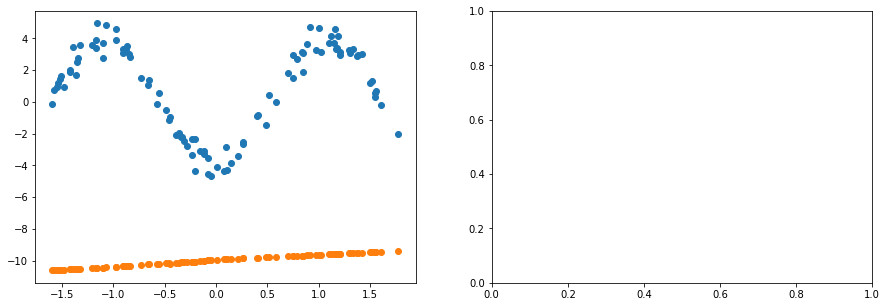

199 loss q(w) -84.112953 p(w) -366.952240 p(y|xw) -835.970398 min -1.274810 mean 1.606648 max 3.967642
199 loss q(w) -82.573006 p(w) -389.454651 p(y|xw) -1689.276001 min -3.777271 mean 0.539929 max 1.836460
199 loss q(w) -87.625725 p(w) -284.800934 p(y|xw) -1273.783325 min -7.370487 mean 1.426669 max 2.327477
199 loss q(w) -84.142624 p(w) -668.088867 p(y|xw) -1300.247803 min 0.039235 mean 0.879112 max 3.616235
199 loss q(w) -91.366089 p(w) -611.908813 p(y|xw) -1688.144165 min 0.642175 mean 1.174636 max 4.385077
199 loss q(w) -83.565002 p(w) -351.145264 p(y|xw) -1853.655151 min -1.712641 mean 1.230267 max 3.619402
199 loss q(w) -76.770287 p(w) -385.536255 p(y|xw) -2056.883545 min -2.978642 mean 1.010565 max 2.339887
199 loss q(w) -102.007446 p(w) -398.306366 p(y|xw) -601.251465 min -3.646783 mean 1.672730 max 5.485653
199 loss q(w) -76.567596 p(w) -612.877869 p(y|xw) -2139.659424 min -1.237739 mean 1.509339 max 3.233068
199 loss q(w) -80.939980 p(w) -725.696289 p(y|xw) -1149.439819 min 

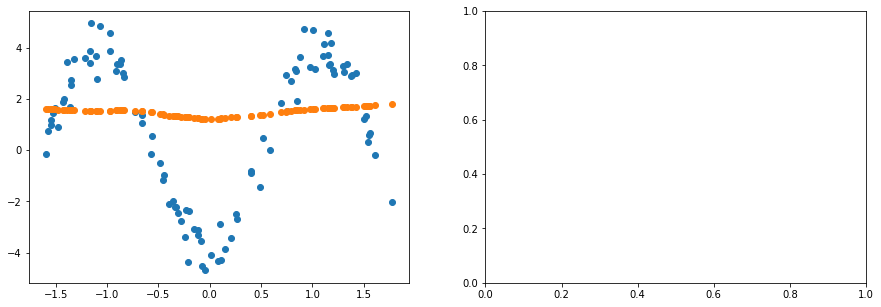

299 loss q(w) -75.210197 p(w) -413.204865 p(y|xw) -604.321594 min -4.132715 mean 0.905260 max 2.047481
299 loss q(w) -66.464226 p(w) -2455.739258 p(y|xw) -399.234619 min -2.569161 mean 1.467135 max 5.371175
299 loss q(w) -81.650726 p(w) -1142.300537 p(y|xw) -466.463409 min -5.798692 mean 0.760678 max 2.401296
299 loss q(w) -76.203865 p(w) -1433.858643 p(y|xw) -528.897583 min -7.034761 mean 0.781469 max 2.894000
299 loss q(w) -67.348709 p(w) -337.723755 p(y|xw) -1419.748413 min 0.092741 mean 0.990143 max 2.274645
299 loss q(w) -69.031044 p(w) -3630.802246 p(y|xw) -2128.145264 min -0.298795 mean 1.246735 max 3.787256
299 loss q(w) -70.169930 p(w) -279.946777 p(y|xw) -968.636841 min 0.513885 mean 1.728705 max 3.380045
299 loss q(w) -79.480400 p(w) -1403.900269 p(y|xw) -597.510071 min -2.674248 mean 1.421364 max 2.341663
299 loss q(w) -76.605965 p(w) -356.375732 p(y|xw) -754.395996 min -6.555833 mean 0.567420 max 2.443094
299 loss q(w) -76.652023 p(w) -2965.731934 p(y|xw) -485.744049 min -

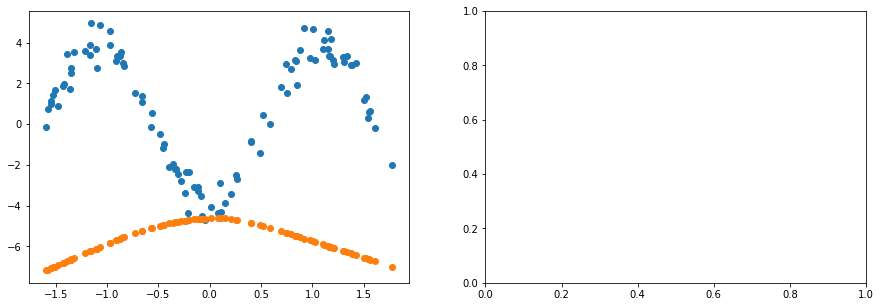

399 loss q(w) -71.796852 p(w) -302.685516 p(y|xw) -523.237976 min -7.012208 mean 0.790731 max 3.118845
399 loss q(w) -75.573669 p(w) -262.388672 p(y|xw) -415.093842 min -5.534620 mean 1.023984 max 2.686218
399 loss q(w) -76.092102 p(w) -316.436279 p(y|xw) -682.519836 min -2.259487 mean 1.307780 max 5.558621
399 loss q(w) -69.463303 p(w) -314.646027 p(y|xw) -384.754730 min -2.656868 mean 0.852663 max 4.454129
399 loss q(w) -70.023750 p(w) -268.715210 p(y|xw) -783.635376 min -5.281139 mean 1.017717 max 3.326561
399 loss q(w) -71.031090 p(w) -286.545654 p(y|xw) -385.475800 min -5.649290 mean 0.730933 max 2.403927
399 loss q(w) -64.865486 p(w) -244.300446 p(y|xw) -1802.163574 min -1.190891 mean 0.569002 max 2.076037
399 loss q(w) -66.531464 p(w) -241.738327 p(y|xw) -1715.811035 min -2.336786 mean 1.183383 max 3.111724
399 loss q(w) -75.604843 p(w) -293.926788 p(y|xw) -447.543610 min -6.152716 mean 1.149120 max 3.417783
399 loss q(w) -72.990570 p(w) -260.674133 p(y|xw) -439.677551 min -6.13

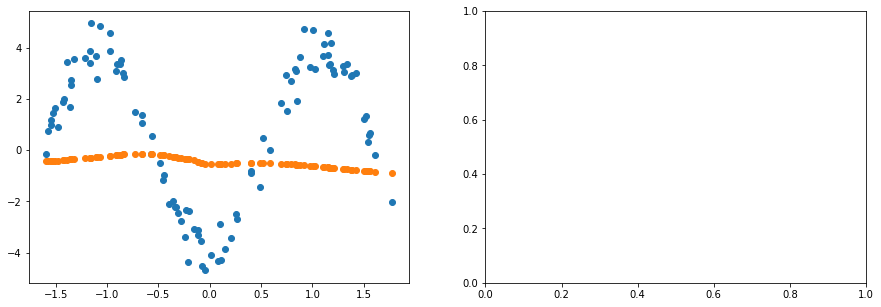

499 loss q(w) -74.505753 p(w) -276.637787 p(y|xw) -480.456726 min -2.344979 mean 0.886448 max 4.651118
499 loss q(w) -72.019073 p(w) -256.008881 p(y|xw) -522.740234 min -5.923836 mean 0.750700 max 2.315390
499 loss q(w) -66.949997 p(w) -261.726501 p(y|xw) -414.036407 min -1.879101 mean 0.994357 max 4.367054
499 loss q(w) -60.642654 p(w) -246.749527 p(y|xw) -1161.730591 min -0.731877 mean 1.234002 max 4.261234
499 loss q(w) -72.529655 p(w) -255.865936 p(y|xw) -425.721954 min -3.435786 mean 0.996836 max 2.522427
499 loss q(w) -64.117477 p(w) -295.349884 p(y|xw) -421.660858 min -3.655922 mean 1.109883 max 2.875201
499 loss q(w) -71.350998 p(w) -253.655457 p(y|xw) -437.205292 min -2.228825 mean 0.836487 max 4.621402
499 loss q(w) -67.326927 p(w) -270.984619 p(y|xw) -443.701019 min -6.902561 mean 0.951127 max 3.028648
499 loss q(w) -69.641983 p(w) -269.102234 p(y|xw) -340.408691 min -6.059392 mean 0.765264 max 2.864203
499 loss q(w) -64.940956 p(w) -259.969818 p(y|xw) -510.797302 min -5.063

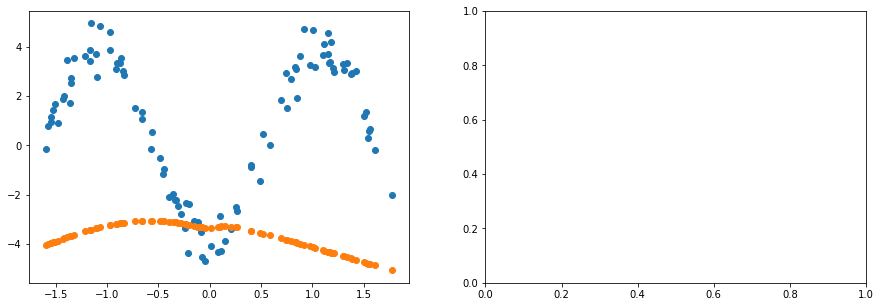

599 loss q(w) -65.977875 p(w) -269.822052 p(y|xw) -339.488281 min -6.059600 mean 0.892083 max 2.958225
599 loss q(w) -66.485588 p(w) -307.893616 p(y|xw) -313.988220 min -4.687352 mean 0.974932 max 2.902001
599 loss q(w) -75.915237 p(w) -325.464203 p(y|xw) -486.068085 min -2.406461 mean 1.008581 max 4.831105
599 loss q(w) -77.670067 p(w) -282.001221 p(y|xw) -301.759979 min -3.489491 mean 0.589767 max 3.532272
599 loss q(w) -66.918182 p(w) -272.245148 p(y|xw) -400.281464 min -3.320745 mean 0.948651 max 4.057209
599 loss q(w) -59.724102 p(w) -337.639893 p(y|xw) -352.457947 min -4.685808 mean 0.994597 max 2.817070
599 loss q(w) -65.784195 p(w) -291.516998 p(y|xw) -399.691559 min -3.243856 mean 1.348777 max 3.217387
599 loss q(w) -68.698761 p(w) -260.068939 p(y|xw) -371.536194 min -1.975707 mean 0.938308 max 4.948809
599 loss q(w) -67.042717 p(w) -262.787048 p(y|xw) -441.741333 min -3.871502 mean 1.434157 max 3.290123
599 loss q(w) -70.753082 p(w) -412.449371 p(y|xw) -380.858643 min -3.6484

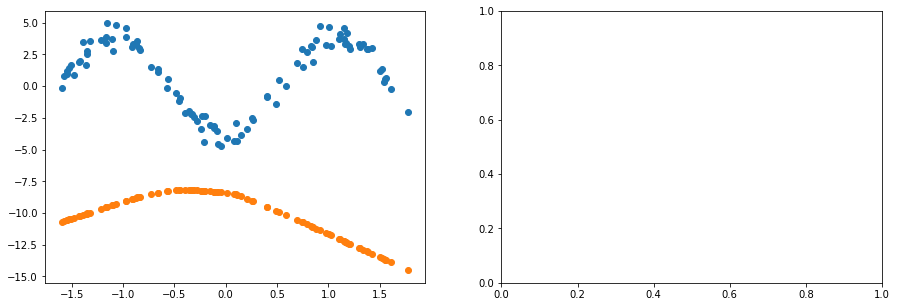

699 loss q(w) -74.292221 p(w) -248.000473 p(y|xw) -374.839966 min -4.635894 mean 1.241912 max 3.208027
699 loss q(w) -68.552612 p(w) -260.537384 p(y|xw) -330.717041 min -4.685484 mean 1.012990 max 2.741307
699 loss q(w) -62.107674 p(w) -248.878418 p(y|xw) -278.239746 min -2.752663 mean 1.142334 max 3.730458
699 loss q(w) -62.283447 p(w) -248.390244 p(y|xw) -954.756897 min -2.743653 mean 1.038125 max 2.874983
699 loss q(w) -72.946434 p(w) -249.955231 p(y|xw) -1222.995972 min -0.980623 mean 0.843473 max 2.549948
699 loss q(w) -67.745659 p(w) -252.243912 p(y|xw) -953.706970 min -1.633582 mean 0.982267 max 3.117041
699 loss q(w) -55.798233 p(w) -261.213684 p(y|xw) -337.661865 min -5.646319 mean 0.881167 max 2.869171
699 loss q(w) -64.249100 p(w) -251.617920 p(y|xw) -1118.387451 min -1.915485 mean 1.166009 max 3.804908
699 loss q(w) -74.516975 p(w) -273.267487 p(y|xw) -399.709137 min -3.074979 mean 0.690647 max 2.411373
699 loss q(w) -58.755825 p(w) -263.232513 p(y|xw) -377.718201 min -5.86

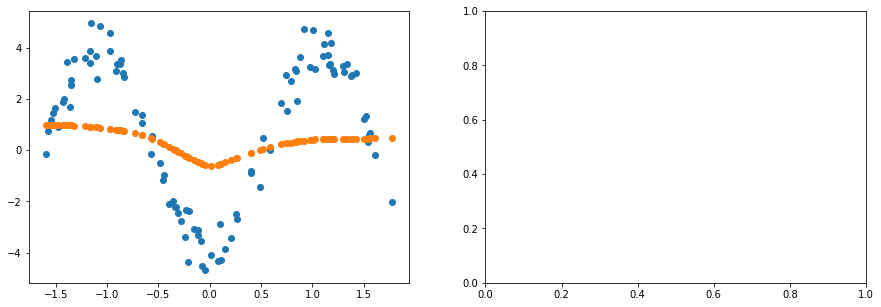

799 loss q(w) -54.627567 p(w) -252.717270 p(y|xw) -1412.283447 min 0.576919 mean 0.956264 max 1.730819
799 loss q(w) -58.827480 p(w) -254.803223 p(y|xw) -286.185150 min -4.534960 mean 0.846016 max 2.796193
799 loss q(w) -56.192368 p(w) -256.434052 p(y|xw) -403.454041 min -4.867221 mean 1.065283 max 3.081684
799 loss q(w) -54.008053 p(w) -256.812225 p(y|xw) -914.780151 min -6.947785 mean 1.054025 max 4.202580
799 loss q(w) -57.536400 p(w) -255.391495 p(y|xw) -323.681641 min -5.628663 mean 0.944630 max 3.073734
799 loss q(w) -70.337082 p(w) -257.702759 p(y|xw) -408.495148 min -6.825211 mean 0.726101 max 3.079186
799 loss q(w) -59.586815 p(w) -263.308685 p(y|xw) -400.155090 min -5.427173 mean 1.286803 max 3.472646
799 loss q(w) -57.984303 p(w) -257.389862 p(y|xw) -356.630249 min -4.832751 mean 1.075850 max 3.024633
799 loss q(w) -66.231873 p(w) -269.678772 p(y|xw) -389.157104 min -6.165092 mean 0.984265 max 3.385838
799 loss q(w) -61.773266 p(w) -257.035004 p(y|xw) -437.334747 min -3.6286

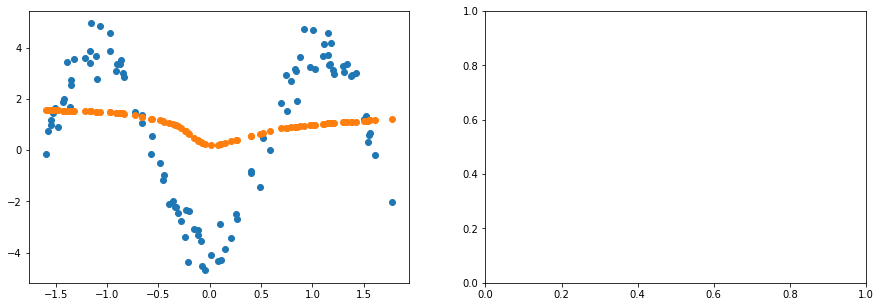

899 loss q(w) -53.479012 p(w) -253.909164 p(y|xw) -298.293640 min -3.677699 mean 1.068286 max 2.867890
899 loss q(w) -59.680347 p(w) -257.169830 p(y|xw) -274.544861 min -4.006868 mean 1.019651 max 2.663394
899 loss q(w) -53.263145 p(w) -254.176025 p(y|xw) -308.760834 min -3.906872 mean 1.001397 max 2.816099
899 loss q(w) -64.515213 p(w) -254.803680 p(y|xw) -311.572876 min -4.601805 mean 0.850447 max 2.860858
899 loss q(w) -81.754906 p(w) -254.041962 p(y|xw) -409.508270 min -3.189901 mean 1.204495 max 3.130605
899 loss q(w) -52.534248 p(w) -253.633896 p(y|xw) -317.762878 min -4.542748 mean 0.981599 max 2.878797
899 loss q(w) -63.730648 p(w) -254.649307 p(y|xw) -325.030823 min -4.404519 mean 1.044652 max 3.030879
899 loss q(w) -74.193466 p(w) -254.189636 p(y|xw) -271.216522 min -4.235884 mean 0.920791 max 2.993147
899 loss q(w) -67.203758 p(w) -254.341034 p(y|xw) -316.723175 min -4.146175 mean 1.020193 max 2.844990
899 loss q(w) -56.322044 p(w) -253.451263 p(y|xw) -287.489594 min -4.6611

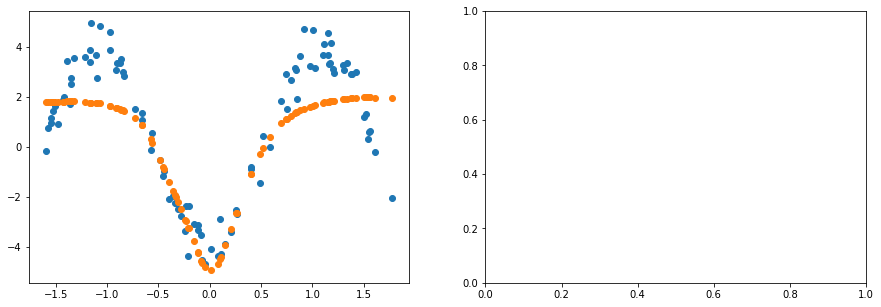

999 loss q(w) -51.327911 p(w) -261.612305 p(y|xw) -158.675018 min -4.454041 mean 1.160779 max 3.918380
999 loss q(w) -54.317852 p(w) -259.988708 p(y|xw) -861.654785 min -2.831336 mean -0.045438 max 1.508614
999 loss q(w) -53.798134 p(w) -261.807922 p(y|xw) -184.883865 min -4.407739 mean 1.140635 max 3.719153
999 loss q(w) -46.002327 p(w) -262.016693 p(y|xw) -209.475388 min -4.732629 mean 1.003779 max 4.449817
999 loss q(w) -58.736008 p(w) -262.756622 p(y|xw) -119.940941 min -4.359074 mean 1.072505 max 4.790720
999 loss q(w) -51.507042 p(w) -261.245636 p(y|xw) -115.265984 min -4.628048 mean 0.752533 max 3.998608
999 loss q(w) -58.785587 p(w) -262.261169 p(y|xw) -130.262115 min -4.091585 mean 1.214610 max 4.450810
999 loss q(w) -41.715530 p(w) -263.108154 p(y|xw) -318.768250 min -4.628065 mean 1.043418 max 4.074644
999 loss q(w) -49.807354 p(w) -261.413971 p(y|xw) -113.953430 min -4.700379 mean 0.977089 max 4.148286
999 loss q(w) -45.559967 p(w) -262.457458 p(y|xw) -279.449860 min -4.454

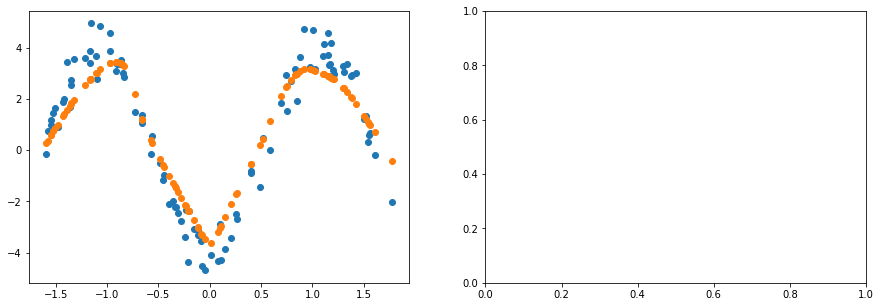

In [16]:
N_SAMPLES = 30
N_EPOCHS = 1000

scaler = StandardScaler()
x_train_norm = torch.tensor(scaler.fit_transform(x_train), dtype=torch.float32)

# model = LinearNet2()
model = TensorLinearNet()
vimodel = VIModel(model)
q_w = vimodel.dist
p_w = normal_prior_dist(model)

# optimizer = torch.optim.Adam(params=vimodel.parameters(), lr=1e-4)
optimizer = torch.optim.SGD(params=vimodel.parameters(), lr=1e-5, 
                            momentum=0.9,
                            weight_decay=1e-4)

def train():
    for i in range(N_EPOCHS):
        model.train()
        with torch.set_grad_enabled(True): 
            optimizer.zero_grad()        
            loss = kl_divergence_nsamples(q_w, p_w, vimodel.loc_dict, model, x_train_norm, y_train, N_SAMPLES, i)
            loss.backward()
            optimizer.step()        
            
        if str(loss.item()) == 'nan':
            break

        if (i+1) % 100== 0:
            # mu = vimodel.eta_mu.detach().numpy()
            # sigma = torch.exp(vimodel.eta_log_sigma.detach()).numpy()
            # print('loss: %f mu: %s sigma: %s' % (loss.detach().numpy(), str(mu), str(sigma)))
            # print(loss.size())
            print('iter: %d loss: %f ' % (i, loss.item(),))

            plt_prediction(q_w, vimodel.loc_dict, model, x_train_norm, y_train, 30)

train()

## prediction

Calculate prediction distribution
$$
\begin{align}
p(y_*| x_*, X, Y) &= \int p(y_*| x_*, W) p(W| X, Y) dW \\
&\approx \int p(y_*| x_*, W) q(W; \eta) dW 
\end{align}
$$

In [0]:
def predict_data(q_w, loc_dict, model, n_samples):    
    x_pred = 5 * torch.rand(100, 1)
    x_pred = torch.tensor(scaler.transform(x_pred), dtype=torch.float32)
    y_pred = predict(q_w, loc_dict, model, x_pred, n_samples)
    
    return x_pred, y_pred


3


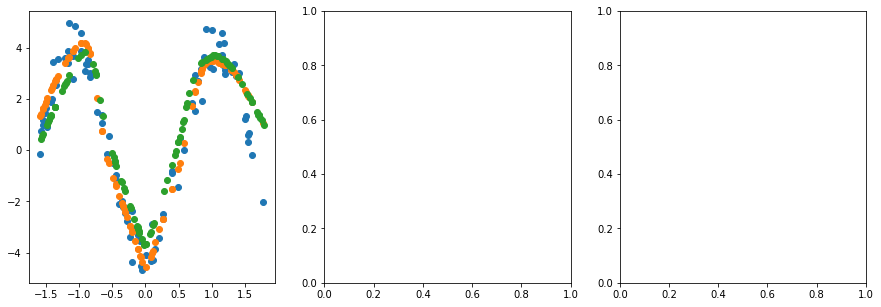

In [19]:
x_pred, y_pred = predict_data(q_w, vimodel.loc_dict, model, 10)
y_pred_train = predict(q_w, vimodel.loc_dict, model, x_train_norm, 10)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
print(len(axes))
axes[0].plot(x_train_norm.numpy(), y_train.numpy(), 'o')
axes[0].plot(x_train_norm.numpy(), y_pred_train.numpy(), 'o')
axes[0].plot(x_pred.numpy(), y_pred.numpy(), 'o')